## Reverse image search and retrieval

Download the dataset from [Caltech-101 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd drive/My\ Drive/Colab\ Notebooks/GSoC

/content/drive/My Drive/Colab Notebooks/GSoC


In [3]:
%pwd

'/content/drive/My Drive/Colab Notebooks/GSoC'

In [4]:
%matplotlib inline
import os
import random
import pickle
import numpy as np
import matplotlib.pyplot
from matplotlib.pyplot import imshow
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from sklearn.decomposition import PCA
from scipy.spatial import distance
from tqdm import tqdm

Using TensorFlow backend.


In [5]:
model = keras.applications.ResNet50(weights='imagenet', include_top=True)
model.summary()














102858752/102853048 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________

In [0]:
def get_image(path):
  # Resize the image to the size that is expected by the input layer of the CNN
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [7]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc1000").output)
feat_extractor.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

Creating an array that has the filenames of the images in the dataset.

In [0]:
images_path = '101_ObjectCategories'
max_num_images = 500

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
if max_num_images < len(images):
  # print(images)
    images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]

Using `tqdm` to show a loading bar as the features of the images are extracted using the RasNet50 CNN.

In [9]:
features = []
for image_path in tqdm(images):
    img, x = get_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)


100%|██████████| 500/500 [05:23<00:00,  1.55it/s]


Store the features onto a file so that you do not have to calculate it everytime.


In [0]:
features = np.array(features)
pickle.dump(features, open('data/features-caltech101-resnet.pickle', 'wb'))
pickle.dump(images, open('data/filenames-caltech101.pickle','wb'))

Load the stored features

In [0]:
images = pickle.load(open('data/filenames-caltech101.pickle', 'rb'))
features = pickle.load(open('data/features-caltech101-resnet.pickle', 'rb'))

Since the CNN outputs a feature vector which has 1000+ dimensions, we need to reduce the dimensionality to (1) visualize the data with ease (2) optimize the time taken to search for a similar image.

Principal Component analysis has been used to reduce the dimensionality with teh least loss in data. 

In [0]:
features = np.array(features)
pca = PCA(n_components=100)
pca.fit(features)
pca_features = pca.transform(features)

Functions to test the search query

In [0]:
def get_closest_images(query_image_idx, num_results=10):
    distances = [distance.euclidean(pca_features[query_image_idx], feat) for feat in pca_features]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Search qeury

Text(0.5, 1.0, 'result images')

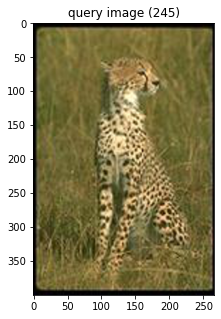

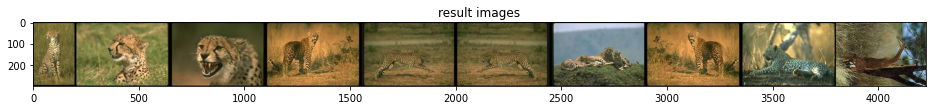

In [19]:
# query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 400)
results_image = get_concatenated_images(idx_closest, 300)

# display the query image
matplotlib.pyplot.figure(figsize = (5,5))
imshow(query_image)
matplotlib.pyplot.title("query image (%d)" % query_image_idx)

# display the resulting images
matplotlib.pyplot.figure(figsize = (16,12))
imshow(results_image)
matplotlib.pyplot.title("result images")